#                              Telco Churn Analysis and Predictive Model

This Predictive analytics model was built on a **Telco Customer Churn** dataset. The goal is to Predict behavior to retain customers and to analyze all relevant customer data and develop focused customer retention programs.

Dataset link: https://www.kaggle.com/datasets/blastchar/telco-customer-churn

Table of Contents:
1. Import Libraries
2. Load and Explore Dataset with Cleaning
3. Exploratory Data Analysis
    - Univariate analysis
    - Multivariate analysis
4. Machine Learning Model Building
    - Baseline Model
    - Hyperparameter tuning
    - Bagging Classifier
    - Stacking Classifier
5. Model Interpretation
    - Lime & Shap interpretation of Stacking Classifier
6. Model Pipeline
7. Deep Learning Model


For this project **Recall** is preferred to be the proper model performance evaluator as the Model needs to be able to detect the Churned customers more accurately than predicting Non-churned customer as Churned. As classifying non-churners to be churners is not detrimental to the business goal but not being able to classify actual churners to be churned is not adequate for the business. Hence **Recall** is the correct metric for this project.

## 1. Import Dependencies (Library)

In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from pretty_confusion_matrix import pp_matrix_from_data
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.combine import SMOTEENN

%matplotlib inline

## 2. Load the Dataset and Exploration

Description of the Dataset: 

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

Customers who left within the last month – the column is called Churn
Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
Demographic info about customers – gender, age range, and if they have partners and dependents

In [27]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [28]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [29]:
df.shape

(7043, 21)

In [30]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [31]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

The `TotalCharges` column is a numerical column but it was assigned as object. The datatype of the column is to be converted to `float64`.

In [32]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

Check for Null and NaN values 

In [33]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [34]:
# Check the percentage of Null/NaN values 
pd.DataFrame((df.isnull().sum() / df.shape[0]) * 100).T

customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0         0.0     0.0            0.0      0.0         0.0     0.0   

   PhoneService  MultipleLines  InternetService  OnlineSecurity  ...  \
0           0.0            0.0              0.0             0.0  ...   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0               0.0          0.0          0.0              0.0       0.0   

   PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  Churn  
0               0.0            0.0             0.0      0.156183    0.0  

[1 rows x 21 columns]

Since only 0.15% of `TotalCharges` colummn is Null values, it is safe to ignore them for further processing

In [35]:
df.dropna(axis = 0, how = 'any', inplace = True)

**Binning the `tenure` column**

In [79]:
print(df['tenure'].max())
print(df['tenure'].min())

72
1


In [71]:
labels = [f'{i} - {i+11}' for i in range(1,72,12)]
labels

['1 - 12', '13 - 24', '25 - 36', '37 - 48', '49 - 60', '61 - 72']

In [77]:
df['tenure_bins'] = pd.cut(df['tenure'], range(1,74,12), right = False, labels = labels)
df['tenure_bins']

0        1 - 12
1       25 - 36
2        1 - 12
3       37 - 48
4        1 - 12
         ...   
7038    13 - 24
7039    61 - 72
7040     1 - 12
7041     1 - 12
7042    61 - 72
Name: tenure_bins, Length: 7032, dtype: category
Categories (6, object): ['1 - 12' < '13 - 24' < '25 - 36' < '37 - 48' < '49 - 60' < '61 - 72']

In [78]:
df['tenure_bins'].value_counts()

1 - 12     2175
61 - 72    1407
13 - 24    1024
25 - 36     832
49 - 60     832
37 - 48     762
Name: tenure_bins, dtype: int64

In [80]:
df.describe()

SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7032.000000  7032.000000     7032.000000   7032.000000
mean        0.162400    32.421786       64.798208   2283.300441
std         0.368844    24.545260       30.085974   2266.771362
min         0.000000     1.000000       18.250000     18.800000
25%         0.000000     9.000000       35.587500    401.450000
50%         0.000000    29.000000       70.350000   1397.475000
75%         0.000000    55.000000       89.862500   3794.737500
max         1.000000    72.000000      118.750000   8684.800000

# 3. Exploratory Data Analysis (EDA)
    a. Univariate Analysis
    b. Multivariate Analysis

#### Univariate Analysis

In [41]:
sns.set_theme()

Text(0.5, 1.0, 'Number of Churns by Gender')

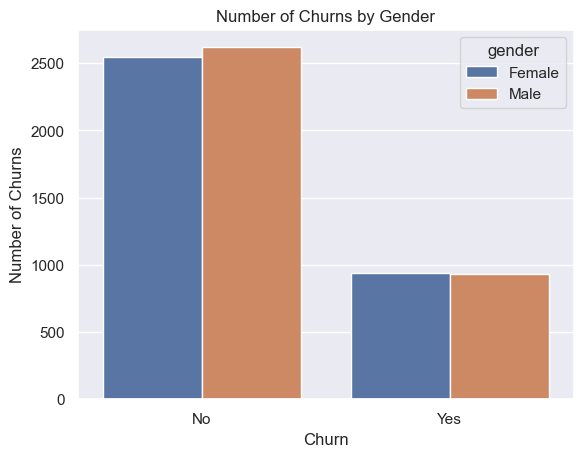

In [44]:
sns.countplot(data = df, x = 'Churn', hue = 'gender')
plt.ylabel('Number of Churns')
plt.title('Number of Churns by Gender')

<AxesSubplot:xlabel='gender', ylabel='count'>

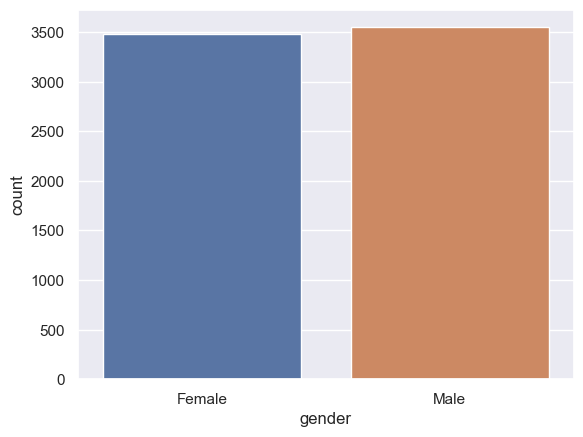

In [45]:
sns.countplot(data = df, x = 'gender')

**There is a balance of gender distribution in the dataset**

<AxesSubplot:xlabel='SeniorCitizen', ylabel='count'>

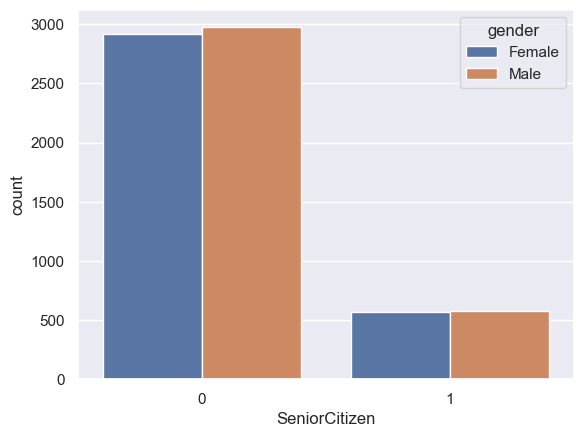

In [47]:
sns.countplot(data = df, x = 'SeniorCitizen', hue = 'gender')

**Balanced number of senior citizen and gender to churn and not churn**

<AxesSubplot:xlabel='gender', ylabel='count'>

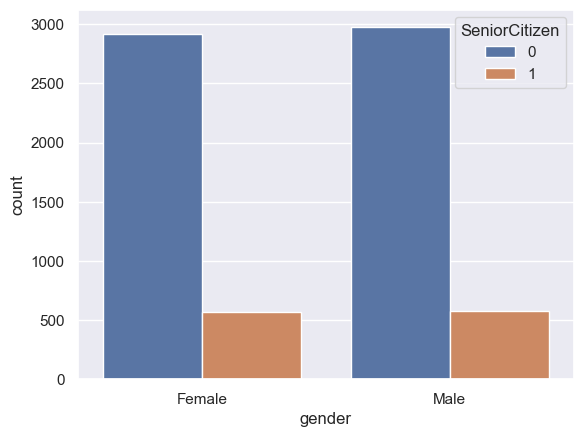

In [52]:
sns.countplot(data = df, x = 'gender', hue = 'SeniorCitizen')

<AxesSubplot:xlabel='Churn', ylabel='count'>

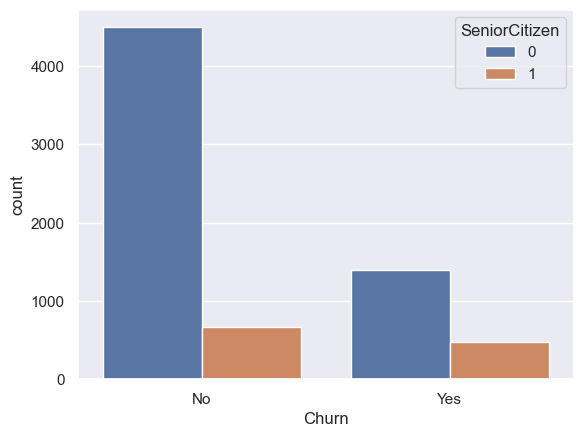

In [51]:
sns.countplot(data = df, x = 'Churn', hue = 'SeniorCitizen')

**Senior Citizens are equally distributed across churn, Non-senior citizens are more likely not churn

In [48]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

<AxesSubplot:xlabel='Partner', ylabel='count'>

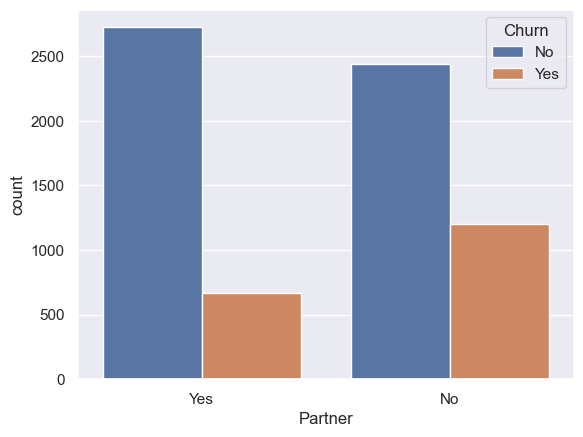

In [50]:
sns.countplot(data = df, x = 'Partner', hue = 'Churn')

**Those who do not have a partner are more likely to churn**

<AxesSubplot:xlabel='Dependents', ylabel='count'>

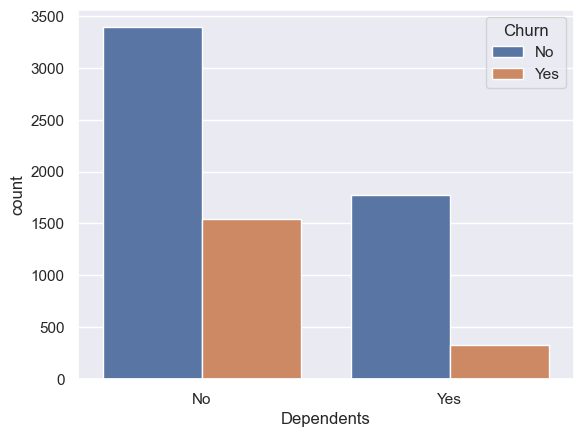

In [53]:
sns.countplot(data = df, x = 'Dependents', hue = 'Churn')

**Those who do not have dependents are more likely to churn**

In [54]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

<AxesSubplot:xlabel='PhoneService', ylabel='count'>

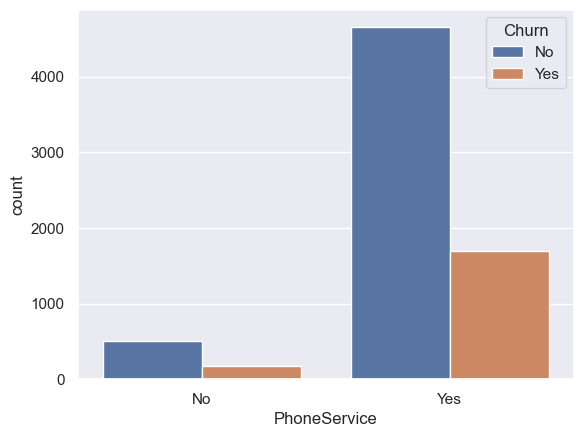

In [55]:
sns.countplot(data = df, x = 'PhoneService', hue = 'Churn')

<AxesSubplot:xlabel='MultipleLines', ylabel='count'>

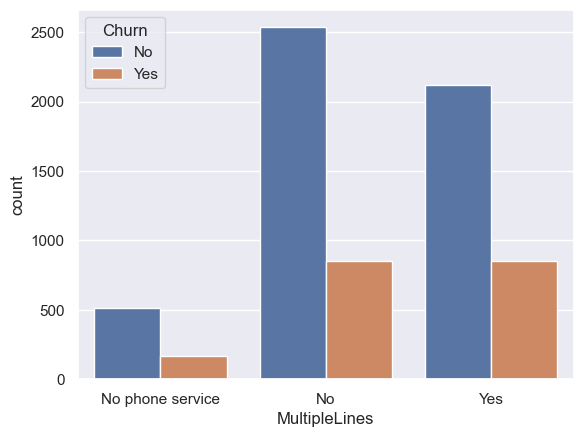

In [56]:
sns.countplot(data = df, x = 'MultipleLines', hue = 'Churn')

<AxesSubplot:xlabel='InternetService', ylabel='count'>

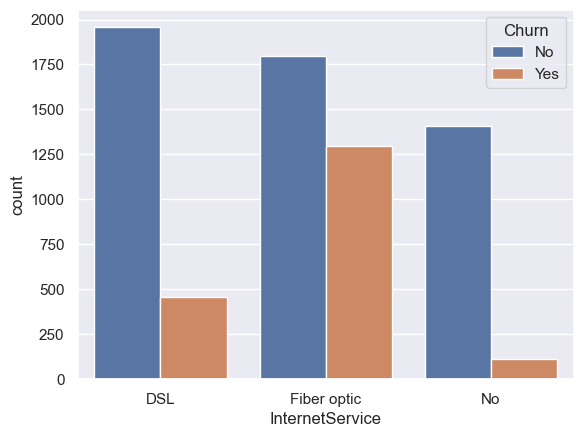

In [57]:
sns.countplot(data = df, x = 'InternetService', hue = 'Churn')

<AxesSubplot:xlabel='OnlineSecurity', ylabel='count'>

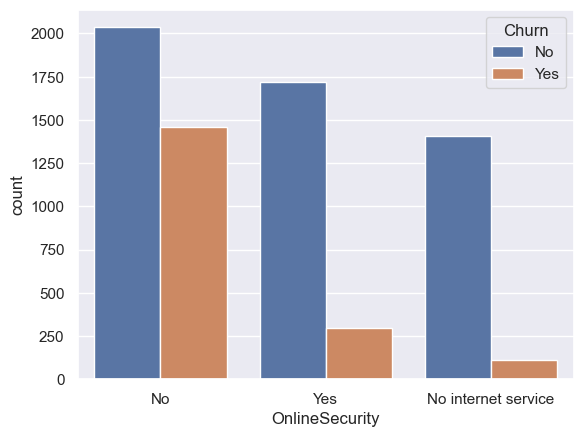

In [58]:
sns.countplot(data = df, x = 'OnlineSecurity', hue = 'Churn')

<AxesSubplot:xlabel='OnlineBackup', ylabel='count'>

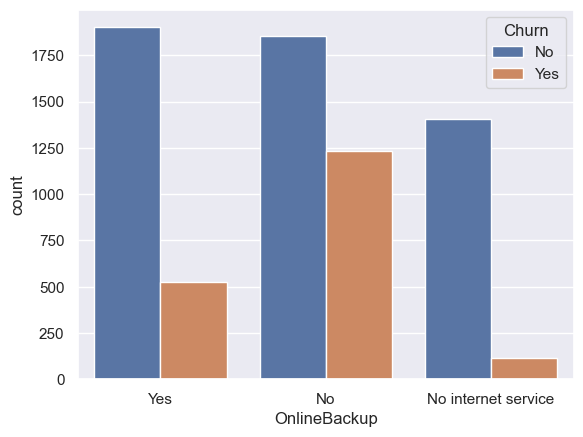

In [59]:
sns.countplot(data = df, x = 'OnlineBackup', hue = 'Churn')

<AxesSubplot:xlabel='DeviceProtection', ylabel='count'>

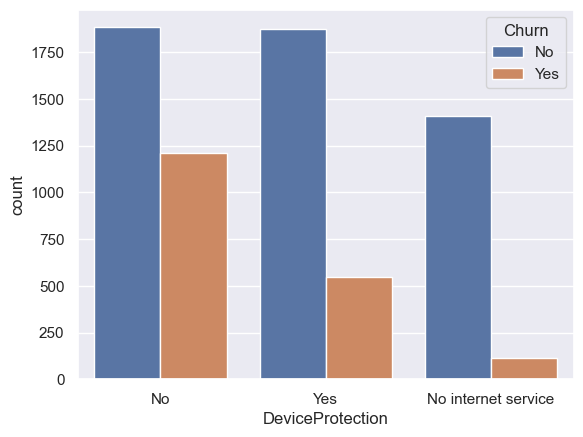

In [60]:
sns.countplot(data = df, x = 'DeviceProtection', hue = 'Churn')

<AxesSubplot:xlabel='TechSupport', ylabel='count'>

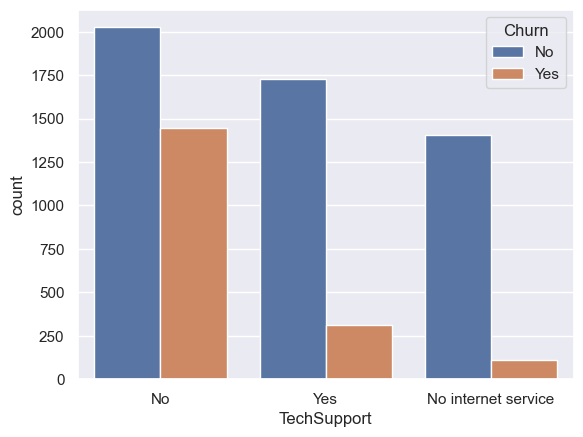

In [61]:
sns.countplot(data = df, x = 'TechSupport', hue = 'Churn')

<AxesSubplot:xlabel='StreamingTV', ylabel='count'>

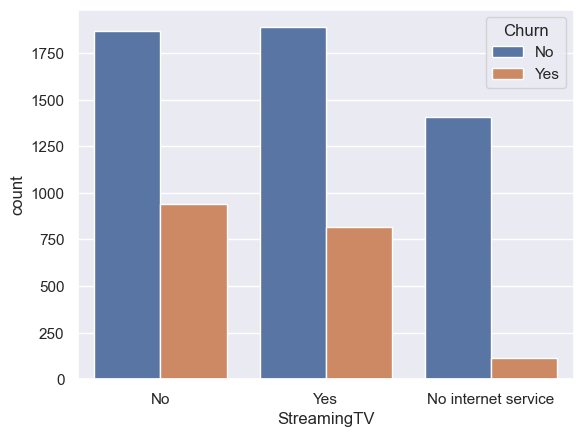

In [62]:
sns.countplot(data = df, x = 'StreamingTV', hue = 'Churn')

<AxesSubplot:xlabel='StreamingMovies', ylabel='count'>

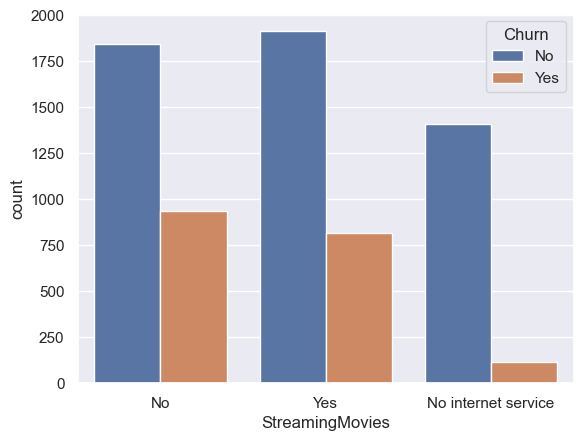

In [63]:
sns.countplot(data = df, x = 'StreamingMovies', hue = 'Churn')

<AxesSubplot:xlabel='Contract', ylabel='count'>

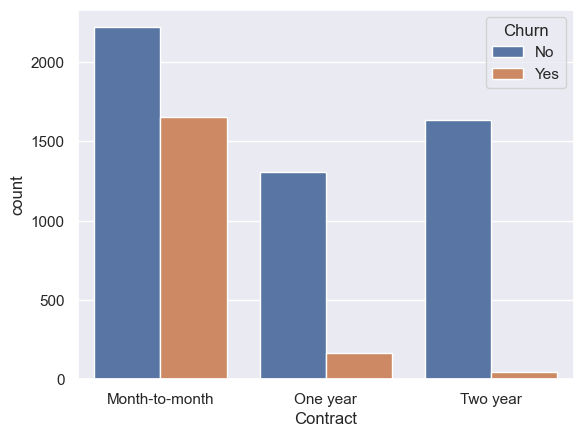

In [64]:
sns.countplot(data = df, x = 'Contract', hue = 'Churn')

<AxesSubplot:xlabel='PaperlessBilling', ylabel='count'>

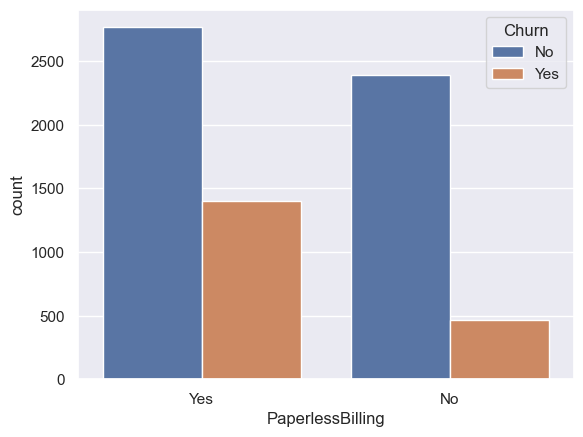

In [65]:
sns.countplot(data = df, x = 'PaperlessBilling', hue = 'Churn')

<AxesSubplot:xlabel='PaymentMethod', ylabel='count'>

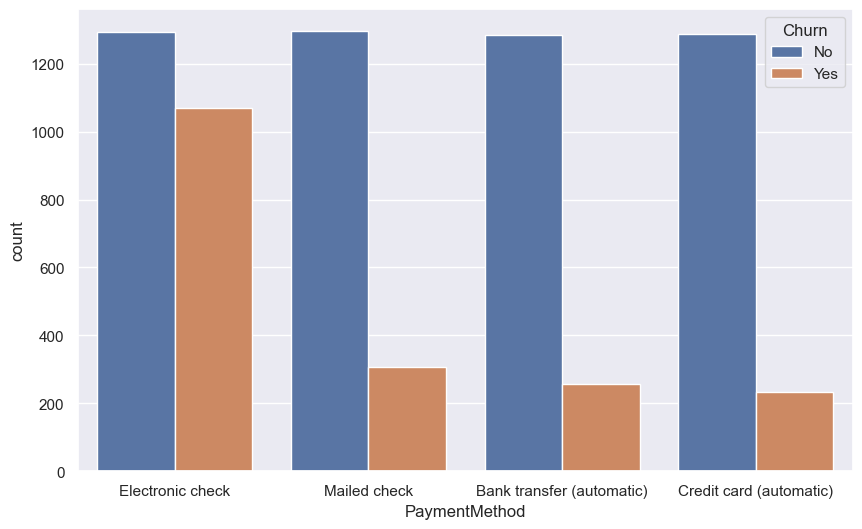

In [67]:
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'PaymentMethod', hue = 'Churn')

<AxesSubplot:xlabel='tenure_bins', ylabel='count'>

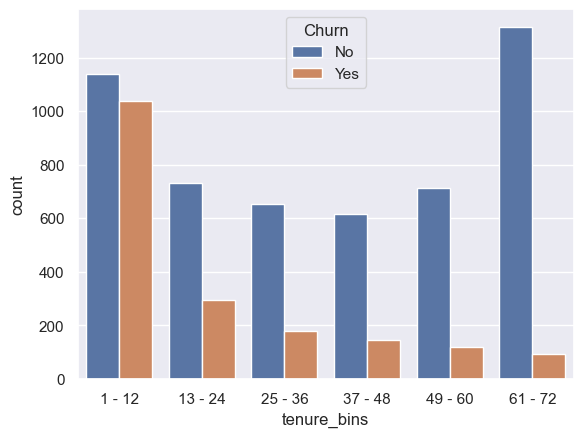

In [81]:
sns.countplot(data = df, x = 'tenure_bins', hue = 'Churn')

**The users who are using the service for less than a year are more likely to churn**

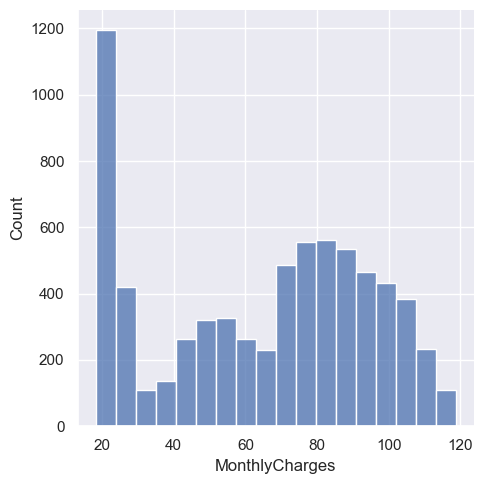

In [96]:
sns.displot(data = df, x = 'MonthlyCharges')

<AxesSubplot:ylabel='MonthlyCharges'>

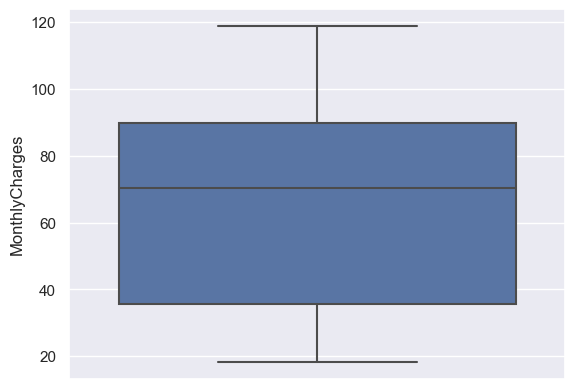

In [102]:
sns.boxplot(data = df, y = 'MonthlyCharges')
#sns.boxplot(data = df, y = 'TotalCharges')

#### Bi-variate Analysis

In [82]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'tenure_bins'],
      dtype='object')

Text(0, 0.5, 'Total Charges')

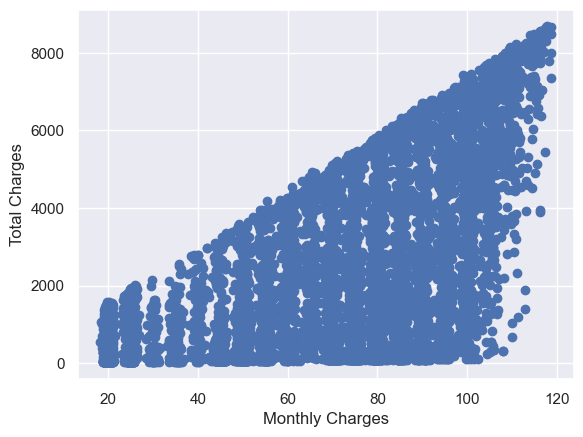

In [84]:
plt.scatter(df['MonthlyCharges'], df['TotalCharges'])
plt.xlabel('Monthly Charges')
plt.ylabel('Total Charges')

**Monthly Charges and Total Charges have a linear relationship. Total charges increase as Monthly charges increase**

In [86]:
df['Churn']

0        No
1        No
2       Yes
3        No
4       Yes
       ... 
7038     No
7039     No
7040     No
7041    Yes
7042     No
Name: Churn, Length: 7032, dtype: object

Text(0.5, 1.0, 'Monthly Charges By Churn')

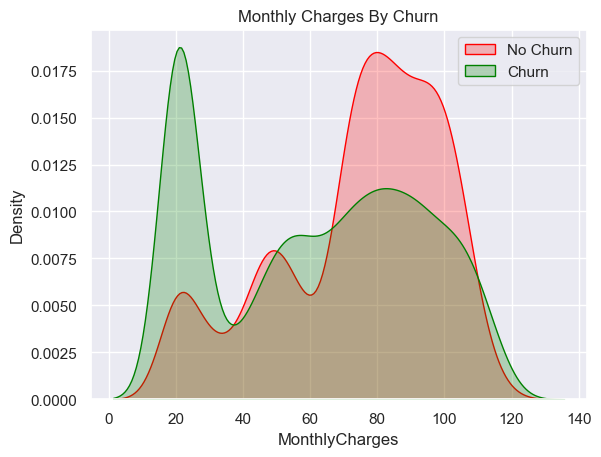

In [105]:
sns.kdeplot(df[df['Churn'] == 'Yes']['MonthlyCharges'], color = 'Red', shade = True)
sns.kdeplot(df[df['Churn'] == 'No']['MonthlyCharges'], color = 'Green', shade = True)
plt.legend(["No Churn","Churn"],loc='upper right')
plt.title('Monthly Charges By Churn')

**Insight** : Higher the Monthly Charges, Higher the Churn

Text(0.5, 1.0, 'Total Charges By Churn')

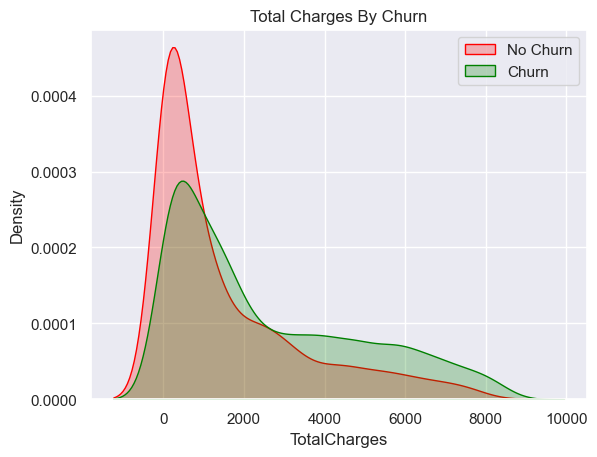

In [106]:
sns.kdeplot(df[df['Churn'] == 'Yes']['TotalCharges'], color = 'Red', shade = True)
sns.kdeplot(df[df['Churn'] == 'No']['TotalCharges'], color = 'Green', shade = True)
plt.legend(["No Churn","Churn"],loc='upper right')
plt.title('Total Charges By Churn')

**Insight** : Lower Total Charges have higher Churn rates

#### Correlation and Heatmap

In [110]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'tenure_bins'],
      dtype='object')

In [117]:
# Create a df with one hot encoded categorical variables
# Drop CustomerID & 'tenure'
df_dummies = df.drop(['customerID', 'tenure'], axis=1) 
# Convert Target Variable into dummy Variable
df_dummies['Churn'] = np.where(df_dummies['Churn'] == 'Yes', 1, 0)
# Get one hot encoded dummy variables for categorical features
df_dummies = pd.get_dummies(df_dummies)
df_dummies.head()

SeniorCitizen  MonthlyCharges  TotalCharges  Churn  gender_Female  \
0              0           29.85         29.85      0              1   
1              0           56.95       1889.50      0              0   
2              0           53.85        108.15      1              0   
3              0           42.30       1840.75      0              0   
4              0           70.70        151.65      1              1   

   gender_Male  Partner_No  Partner_Yes  Dependents_No  Dependents_Yes  ...  \
0            0           0            1              1               0  ...   
1            1           1            0              1               0  ...   
2            1           1            0              1               0  ...   
3            1           1            0              1               0  ...   
4            0           1            0              1               0  ...   

   PaymentMethod_Bank transfer (automatic)  \
0                                        0   
1                                        0   
2                                        0   
3                                        1   
4                                        0   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   

   PaymentMethod_Mailed check  tenure_bins_1 - 12  tenure_bins_13 - 24  \
0                           0                   1                    0   
1                           1                   0                    0   
2                           1                   1                    0   
3                           0                   0                    0   
4                           0                   1                    0   

   tenure_bins_25 - 36  tenure_bins_37 - 48  tenure_bins_49 - 60  \
0                    0                    0                    0   
1                    1                    0                    0   
2                    0                    0                    0   
3                    0                    1                    0   
4                    0                    0                    0   

   tenure_bins_61 - 72  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  

[5 rows x 51 columns]

In [118]:
df_dummies.columns

Index(['SeniorCitizen', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'gender_Female', 'gender_Male', 'Partner_No', 'Partner_Yes',
       'Dependents_No', 'Dependents_Yes', 'PhoneService_No',
       'PhoneService_Yes', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'P

<AxesSubplot:>

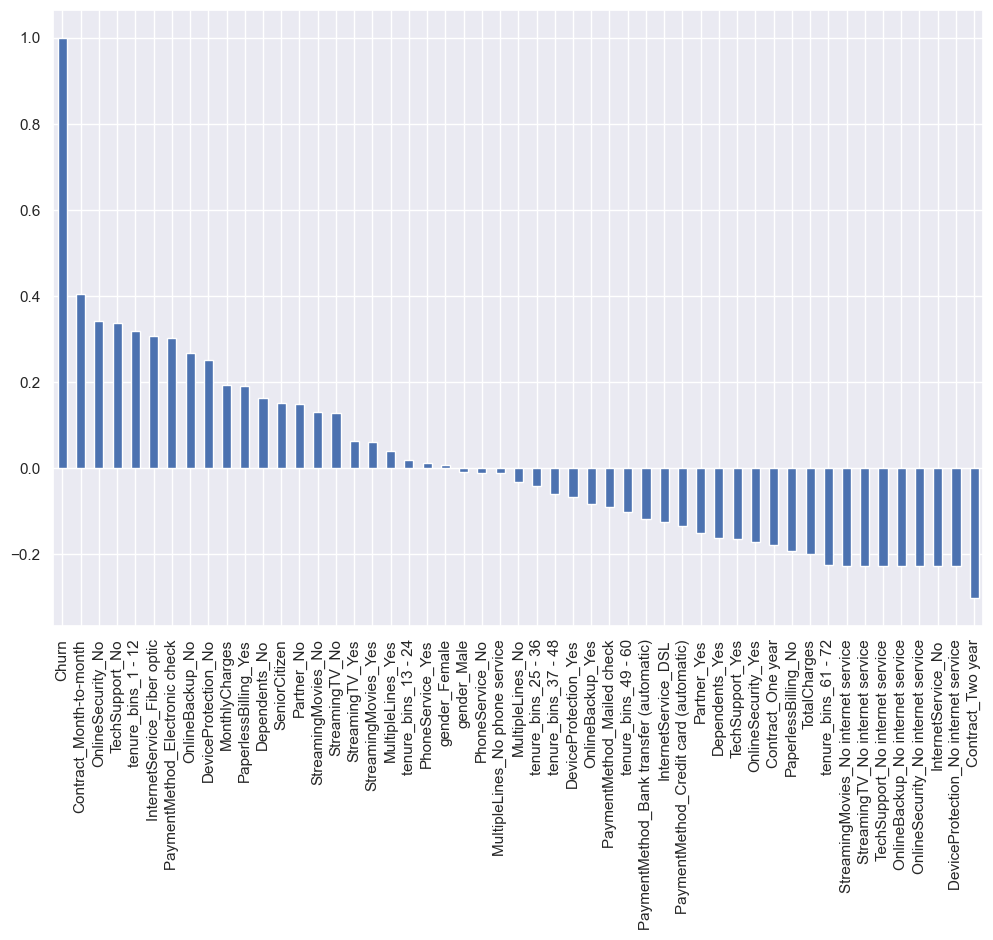

In [123]:
plt.figure(figsize = (12, 8))
df_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind = 'bar')


**Insights** :
1. High Churn with Month-to-month contract, No online security, No tech support, subscription under 1 year and Fiber optic internet service.
2. Low Churn with Two year contracts, No internet service, and tenure more than 5 years
3. Gender, subscription in phone service, and number of lines seems to have negligible effect.

<AxesSubplot:>

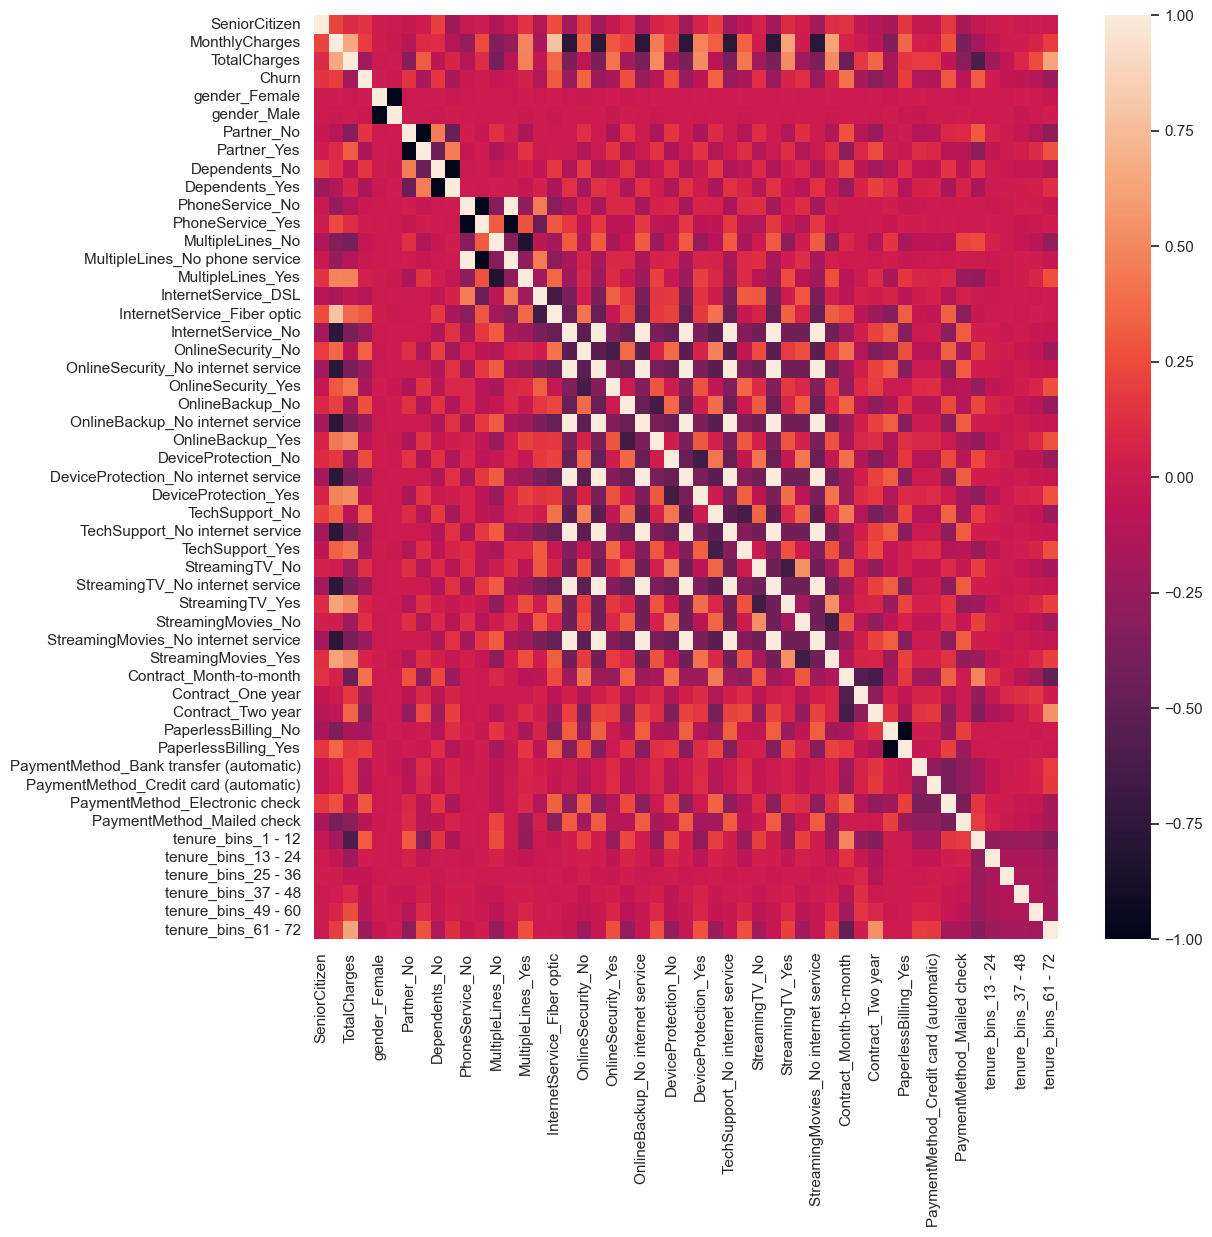

In [125]:
plt.figure(figsize=(12,12))
sns.heatmap(df_dummies.corr())

In [131]:
#df_dummies.to_csv('clean_dummies.csv')

In [133]:
#df.to_csv('clean.csv')

# 4. Machine Learning Model Building

In [130]:
df_dummies.head()

SeniorCitizen  MonthlyCharges  TotalCharges  Churn  gender_Female  \
0              0           29.85         29.85      0              1   
1              0           56.95       1889.50      0              0   
2              0           53.85        108.15      1              0   
3              0           42.30       1840.75      0              0   
4              0           70.70        151.65      1              1   

   gender_Male  Partner_No  Partner_Yes  Dependents_No  Dependents_Yes  ...  \
0            0           0            1              1               0  ...   
1            1           1            0              1               0  ...   
2            1           1            0              1               0  ...   
3            1           1            0              1               0  ...   
4            0           1            0              1               0  ...   

   PaymentMethod_Bank transfer (automatic)  \
0                                        0   
1                                        0   
2                                        0   
3                                        1   
4                                        0   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   

   PaymentMethod_Mailed check  tenure_bins_1 - 12  tenure_bins_13 - 24  \
0                           0                   1                    0   
1                           1                   0                    0   
2                           1                   1                    0   
3                           0                   0                    0   
4                           0                   1                    0   

   tenure_bins_25 - 36  tenure_bins_37 - 48  tenure_bins_49 - 60  \
0                    0                    0                    0   
1                    1                    0                    0   
2                    0                    0                    0   
3                    0                    1                    0   
4                    0                    0                    0   

   tenure_bins_61 - 72  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  

[5 rows x 51 columns]

In [137]:
# Feature Variables
X = df_dummies.drop('Churn', axis = 1) 
# Target Variables
y = df_dummies['Churn']

In [138]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

#### Baseline Model: Decision Tree Classifier

In [157]:
dt = DecisionTreeClassifier(random_state = 42, max_depth = 5)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [158]:
y_pred = dt.predict(X_test)
y_pred

array([0, 1, 1, ..., 0, 0, 0])

In [159]:
dt.score(X_test, y_test)

0.7917555081734187

In [160]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.63      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407



[[918 115]
 [178 196]]


<AxesSubplot:>

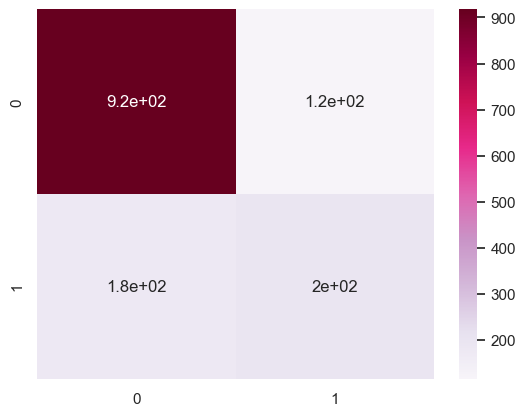

In [179]:
print(confusion_matrix(y_test, y_pred))
df_cm = confusion_matrix(y_test, y_pred)
cmap = 'PuRd'
sns.heatmap(df_cm, annot = True, cmap = cmap)

In [166]:
# Cross Validation Score
kf = KFold(n_splits=5, shuffle=True, random_state=5)

dt = DecisionTreeClassifier(random_state = 42, max_depth = 5)

# Compute 5-fold cross-validation scores
cv_scores = cross_val_score(dt, X_train,y_train, cv=kf)

# Print scores
print(cv_scores)
print(np.mean(cv_scores))
print(np.std(cv_scores))
print(np.quantile(cv_scores, [0.025, 0.975]))

[0.78311111 0.77866667 0.792      0.78044444 0.78133333]
0.7831111111111111
0.004669840190778222
[0.77884444 0.79111111]


The Accuray is 78.31%. It is an imbalanced dataset, hence accuracy is not a good metric to evaluate.

Analyzing the precision, recall and f1 score for class 1 minority class, it is evident that all 3 scores are too low.

#### **Now, we will apply SMOTEEN Upsampling method and train the model again**

In [183]:
sm = SMOTEENN()
X_train_resampled, y_train_resampled = sm.fit_resample(X_train,y_train)

In [184]:
X_train.shape

(5625, 50)

In [185]:
X_train_resampled.shape

(4658, 50)

In [186]:
y_train.value_counts()

0    4130
1    1495
Name: Churn, dtype: int64

In [187]:
y_train_resampled.value_counts()

1    2549
0    2109
Name: Churn, dtype: int64

In [188]:
# Train Decision tree on resampled data

In [190]:
dt_sm = DecisionTreeClassifier(random_state = 42, max_depth = 5)
dt_sm.fit(X_train_resampled, y_train_resampled)
y_pred_sm = dt_sm.predict(X_test)
score_sm = dt_sm.score(X_test, y_test)
print(score_sm)
print(classification_report(y_test, y_pred_sm))

0.7526652452025586
              precision    recall  f1-score   support

           0       0.90      0.74      0.82      1033
           1       0.52      0.78      0.63       374

    accuracy                           0.75      1407
   macro avg       0.71      0.76      0.72      1407
weighted avg       0.80      0.75      0.76      1407



In [191]:
confusion_matrix(y_test, y_pred_sm)

array([[767, 266],
       [ 82, 292]])

As we can see, the overall F1 score after up-sampling is significantly higher than that of before up-sampling. In our case, **Recall** is important which is the percentage of actual positives that were correctly classified. Recall is up to 78% from 52% after upsampling. The model is performing better at predicting Churns. Note that, the test dataset was not upsampled. Now, we will look at the cross validation score for DecisionTree Model after upsampling the training Data.

In [192]:
# Cross validation
# Cross Validation Score
kf = KFold(n_splits=5, shuffle=True, random_state=5)

dt = DecisionTreeClassifier(random_state = 42, max_depth = 5)

# Compute 5-fold cross-validation scores
cv_scores = cross_val_score(dt, X_train_resampled,y_train_resampled, cv=kf)

# Print scores
print(cv_scores)
print(np.mean(cv_scores))
print(np.std(cv_scores))
print(np.quantile(cv_scores, [0.025, 0.975]))

[0.92703863 0.91416309 0.93133047 0.93125671 0.92051557]
0.924860895340743
0.00664573955929259
[0.91479834 0.9313231 ]


The Cross-Validation Score has gone up to 92.48% from that of 78.31%. And overall F1 score is also higher for this model on test data. We will perform a **Grid Search** on DT classifier to look for a better tuned parameters. 

##### Hyper Parameter Tuning of DT classifier with Grid-Search

In [ ]:
# Set up the parameter grid
param_grid = {"alpha": np.linspace(0.00001, 1, 20)}

# Instantiate lasso_cv
lasso_cv = GridSearchCV(lasso, param_grid, cv=kf)

# Fit to the training data
lasso_cv.fit(X_train, y_train)
print("Tuned lasso paramaters: {}".format(lasso_cv.best_params_))
print("Tuned lasso score: {}".format(lasso_cv.best_score_))

In [199]:
kf = KFold(n_splits=5, shuffle=True, random_state=5)
param_grid = {'criterion' : ['gini', 'entropy'],
             'max_depth' : [2,4,6,8,10,12,15],
             'min_samples_leaf' : [2,4,6,8,10,12,15]}
dt_gs = DecisionTreeClassifier()

dt_cv = GridSearchCV(dt_gs, param_grid, cv = kf)

dt_cv.fit(X_train_resampled, y_train_resampled)

print("Tuned DT paramaters: {}".format(dt_cv.best_params_))
print("Tuned DT score: {}".format(dt_cv.best_score_))

Tuned DT paramaters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 8}
Tuned DT score: 0.9409594648792428


We can see after hyperparameter Tuning, the accuracy has gone up from 92% to 94%. We can see the tuned parameters. Now lets see how the model performs on test data.

In [200]:
y_pred_gs = dt_cv.predict(X_test)
print(dt_cv.score(X_test, y_test))
print(classification_report(y_test, y_pred_gs))

0.7782515991471215
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1033
           1       0.56      0.74      0.64       374

    accuracy                           0.78      1407
   macro avg       0.73      0.77      0.74      1407
weighted avg       0.81      0.78      0.79      1407



Precision, Recall and F1 score along with overall Accuracy has improved for predicting Churn class 1 on test data after hyperparameter tuning. Overall accuracy has gone up by 3%. Now we will look into a **Ensemble Bagging method** called **Random Forest Classifier**.

#### Random Forest Classifier

In [203]:
rf = RandomForestClassifier()
rf.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf.predict(X_test)

In [204]:
rf.score(X_test, y_test)

0.7903340440653873

In [206]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1033
           1       0.58      0.74      0.65       374

    accuracy                           0.79      1407
   macro avg       0.74      0.77      0.75      1407
weighted avg       0.81      0.79      0.80      1407



We can see, **Random Forest Classifier** without any hyperparameter tuning performs better with higher Precision, Recall, f1 score and accuracy than that of **Decision Tree Classifier**. We will tune the hyperparameters for this model and see how it performs.

**Hyper-parameter tuning for Random Forest Classifier**

In [208]:
kf = KFold(n_splits=5, shuffle=True, random_state=5)
param_grid = {'criterion' : ['gini', 'entropy', 'log_loss'],
             'max_depth' : [2,4,6,8,10,12,15],
             'min_samples_leaf' : [2,4,6,8,10,12,15]}
rf_gs = RandomForestClassifier()

rf_cv = GridSearchCV(rf_gs, param_grid, cv = kf)

rf_cv.fit(X_train_resampled, y_train_resampled)

print("Tuned RF paramaters: {}".format(rf_cv.best_params_))
print("Tuned RF score: {}".format(rf_cv.best_score_))

Tuned RF paramaters: {'criterion': 'log_loss', 'max_depth': 15, 'min_samples_leaf': 2}
Tuned RF score: 0.9516929970542541


In [209]:
y_pred_rfgs = dt_cv.predict(X_test)
print(dt_cv.score(X_test, y_test))
print(classification_report(y_test, y_pred_rfgs))

0.7782515991471215
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1033
           1       0.56      0.74      0.64       374

    accuracy                           0.78      1407
   macro avg       0.73      0.77      0.74      1407
weighted avg       0.81      0.78      0.79      1407



The Model doesnt seem to have improved much after hyperparameter tuning on Randon Forest Classifier. Now we will implement a **Stacking Classifier** model and see how that performs.

### Stacking Classifier

In [214]:
kf = KFold(n_splits=5, shuffle=True, random_state=5)
# Create a Randomforest classifier
forest = RandomForestClassifier(n_estimators=100, random_state=123)

# Create a XGBoost classifier
boost = XGBClassifier(random_state=123, verbosity=0)

# Create a Logistic regression classifier
lgclassifier = LogisticRegression(random_state=123)

# Create a stacking classifier
estimators = [
     ('rf', forest),
     ('xgb', boost)
]
sclf = StackingClassifier(estimators=estimators,
                            final_estimator=lgclassifier,
                            cv=kf)

In [215]:
sclf.fit(X_train_resampled, y_train_resampled)
y_pred_sclf = sclf.predict(X_test)
print(sclf.score(X_test, y_test))
print(classification_report(y_test, y_pred_sclf))

0.7924662402274343
              precision    recall  f1-score   support

           0       0.89      0.82      0.85      1033
           1       0.59      0.73      0.65       374

    accuracy                           0.79      1407
   macro avg       0.74      0.77      0.75      1407
weighted avg       0.81      0.79      0.80      1407



In [217]:
## Cross-Validation for Stacking Classifier

# Cross Validation Score
kf = KFold(n_splits=5, shuffle=True, random_state=5)

sclf_cv = StackingClassifier(estimators=estimators,
                            final_estimator=lgclassifier,
                            cv=kf)

# Compute 5-fold cross-validation scores
cv_scores = cross_val_score(sclf_cv, X_train_resampled,y_train_resampled, cv=kf)

# Print scores
print(cv_scores)
print(np.mean(cv_scores))
print(np.std(cv_scores))
print(np.quantile(cv_scores, [0.025, 0.975]))

[0.95600858 0.96351931 0.96137339 0.95488722 0.94951665]
0.957061030872706
0.004960981086373564
[0.95005371 0.96330472]


[[843 190]
 [102 272]]


<AxesSubplot:>

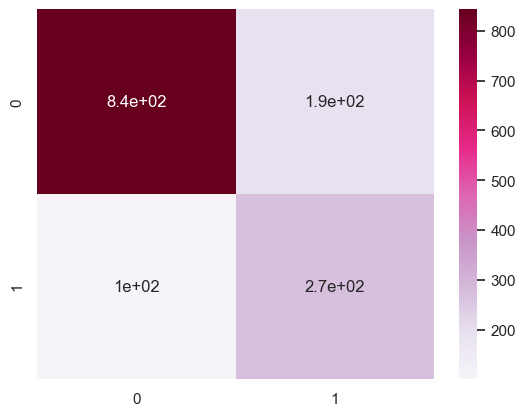

In [218]:
print(confusion_matrix(y_test, y_pred_sclf))
df_cm = confusion_matrix(y_test, y_pred_sclf)
cmap = 'PuRd'
sns.heatmap(df_cm, annot = True, cmap = cmap)

**Stacking Classifier** outperforms all other Classifiers in terms of all of the metrics on test Data. The highest overall accuracy on test dataset was 79.24% and cross validation accuracy of 95.70%. For out case, the best metric for this model is to predict the Churned customer as Churned which is **Recall**. The recall is 73% which is not too low that overall accuracy. The **precision** is 59% which is better than all other models. Hence **Stacking Classifier** is the best model for this particular Churn Analysis model.

# 5. Model Interpretaion
### LIME & SHAP

#### LIME Model Interpretation

In [245]:
from lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(X_train_resampled.values,
                                 feature_names=X_train_resampled.columns.values,
                                 class_names=['Not Churned', 'Churned'])

In [246]:
y_proba = sclf.predict_proba(X_test)[:, 1]
y_proba

array([0.01477944, 0.97863362, 0.98337676, ..., 0.01549759, 0.02360187,
       0.01711318])

In [247]:
result = X_test.copy()

result['predicted_proba'] = y_proba

result['true_label'] = y_test

result[result['true_label'] == 1].sort_values('predicted_proba', ascending=True).head(5)

SeniorCitizen  MonthlyCharges  TotalCharges  gender_Female  gender_Male  \
6792              0           24.90       1334.00              0            1   
4795              0           20.80       1021.80              1            0   
1780              0           20.15        390.85              1            0   
3971              0           24.75        692.10              1            0   
2536              0           25.30        676.35              0            1   

      Partner_No  Partner_Yes  Dependents_No  Dependents_Yes  PhoneService_No  \
6792           1            0              1               0                0   
4795           0            1              1               0                0   
1780           1            0              0               1                0   
3971           1            0              1               0                0   
2536           1            0              1               0                0   

      ...  PaymentMethod_Electronic check  PaymentMethod_Mailed check  \
6792  ...                               1                           0   
4795  ...                               0                           0   
1780  ...                               0                           0   
3971  ...                               0                           0   
2536  ...                               0                           0   

      tenure_bins_1 - 12  tenure_bins_13 - 24  tenure_bins_25 - 36  \
6792                   0                    0                    0   
4795                   0                    0                    0   
1780                   0                    1                    0   
3971                   0                    0                    1   
2536                   0                    0                    1   

      tenure_bins_37 - 48  tenure_bins_49 - 60  tenure_bins_61 - 72  \
6792                    0                    1                    0   
4795                    0                    1                    0   
1780                    0                    0                    0   
3971                    0                    0                    0   
2536                    0                    0                    0   

      predicted_proba  true_label  
6792         0.014759           1  
4795         0.014761           1  
1780         0.014762           1  
3971         0.014767           1  
2536         0.014774           1  

[5 rows x 52 columns]

In [248]:
customer_id = 6792

exp = explainer.explain_instance(X_test.loc[customer_id], sclf.predict_proba)

exp.show_in_notebook()

/Users/shadman/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [249]:
customer_id = 4795

exp = explainer.explain_instance(X_test.loc[customer_id], sclf.predict_proba)

exp.show_in_notebook()

/Users/shadman/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


The Model Interpretation through Lime Explainer indicates that the Monthly charges of the customers that were predicted not Churned but in actual was churned have infact had a major weight in the probability. Other than monthly charges, No Internet service was a major determiner for the model to make wrong prediction. Then there are contracts of less than 1 year and billing systems as features that swayed the prediction. 

### Shap Model Interpretation

In [250]:
import shap
shap.initjs()

explainer = shap.KernelExplainer(sclf.predict_proba, X_train_resampled, link='logit')
shap_values = explainer.shap_values(X_test, nsamples=100)

shap.force_plot(explainer.expected_value[0], shap_values[0][0, :], X_test.iloc[0, :], link='logit')

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Using 4658 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1407 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage.

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage.

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage.

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage.

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage.

KeyboardInterrupt: 

# 6. ML Pipeline

In [299]:
#from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.pipeline import Pipeline, make_pipeline

In [271]:
df = pd.read_csv('clean.csv')

In [272]:
df.drop('Unnamed: 0', axis = 1, inplace = True)
df['Churn'] = np.where(df['Churn'] == 'Yes', 1, 0)
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... TechSupport  \
0  No phone service             DSL             No  ...          No   
1                No             DSL            Yes  ...          No   
2                No             DSL            Yes  ...          No   
3  No phone service             DSL            Yes  ...         Yes   
4                No     Fiber optic             No  ...          No   

  StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No              No  Month-to-month              Yes   
1          No              No        One year               No   
2          No              No  Month-to-month              Yes   
3          No              No        One year               No   
4          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges TotalCharges  Churn  tenure_bins  
0           Electronic check          29.85        29.85      0       1 - 12  
1               Mailed check          56.95      1889.50      0      25 - 36  
2               Mailed check          53.85       108.15      1       1 - 12  
3  Bank transfer (automatic)          42.30      1840.75      0      37 - 48  
4           Electronic check          70.70       151.65      1       1 - 12  

[5 rows x 22 columns]

In [279]:
X = df.drop('Churn', axis = 1)
y = df['Churn']

In [283]:
# Train test Split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [297]:
CATEGORICAL_FEATURES = list(X.select_dtypes(include='object').columns)
NUMERICAL_FEATURES = list(X.select_dtypes(include = 'number').columns)
CATEGORICAL_FEATURES.remove('customerID')
NUMERICAL_FEATURES.remove('tenure')
print(CATEGORICAL_FEATURES)
print(NUMERICAL_FEATURES)

['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_bins']
['SeniorCitizen', 'MonthlyCharges', 'TotalCharges']


In [326]:
CATEGORICAL_FEATURES

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'tenure_bins']

In [254]:
# Define a Custom Transformer for Dropping Columns
class columnDropperTransformer():
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self 

In [335]:
#one hot encoding
ohe = ColumnTransformer([
    ('ohe',OneHotEncoder(sparse=False,handle_unknown='ignore'),CATEGORICAL_FEATURES)
],remainder='passthrough')
#MinMaxScaler
scaler = ColumnTransformer([
    ('scale', MinMaxScaler())
], remainder = 'passthrough')

In [336]:
##### Define the Stacking Classifier Model
kf = KFold(n_splits=5, shuffle=True, random_state=5)
# Create a Randomforest classifier
forest = RandomForestClassifier(n_estimators=100, random_state=123)

# Create a XGBoost classifier
boost = XGBClassifier(random_state=123, verbosity=0)

# Create a Logistic regression classifier
lgclassifier = LogisticRegression(random_state=123)

# Create a stacking classifier
estimators = [
     ('rf', forest),
     ('xgb', boost)
]
sclf = StackingClassifier(estimators=estimators,
                            final_estimator=lgclassifier,
                            cv=kf)

In [337]:
sm = SMOTEENN()

In [343]:
# Define the Pipeline
pipeline = Pipeline([
    ("columnDropper", columnDropperTransformer(['customerID','tenure'])),
    ("ohe", ohe),
    ('scaler', MinMaxScaler()),
    ("sm", sm),
    ("sclf", sclf)
])

In [344]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columnDropper',
                 <__main__.columnDropperTransformer object at 0x7f77ff03da30>),
                ('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'Te...
                                                               interaction_constraints=None,
                                                               learning_rate=None,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=123, ...))],
                                    final_estimator=LogisticRegression(random_state=123)))])

In [345]:
pipeline.named_steps

{'columnDropper': <__main__.columnDropperTransformer at 0x7f77ff03da30>,
 'ohe': ColumnTransformer(remainder='passthrough',
                   transformers=[('ohe',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  ['gender', 'Partner', 'Dependents',
                                   'PhoneService', 'MultipleLines',
                                   'InternetService', 'OnlineSecurity',
                                   'OnlineBackup', 'DeviceProtection',
                                   'TechSupport', 'StreamingTV',
                                   'StreamingMovies', 'Contract',
                                   'PaperlessBilling', 'PaymentMethod',
                                   'tenure_bins'])]),
 'scaler': MinMaxScaler(),
 'sm': SMOTEENN(),
 'sclf': StackingClassifier(cv=KFold(n_splits=5, random_state=5, shuffle=True),
                    estimators=[('r

In [346]:
y_pred = pipeline.predict(X_test)

In [347]:
pipeline.score(X_test, y_test)

0.7299218194740583

In [350]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1033
           1       0.49      0.78      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407



The Pipeline has the highest recall of 78% for Churn prediction which is an indicator of a very effective model

# 7. Deep Learning Model

In [351]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [360]:
# Feature Variables
X = df_dummies.drop('Churn', axis = 1) 
# Target Variables
y = df_dummies['Churn']

In [361]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [371]:
model = Sequential()

In [379]:
model = Sequential()

# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw


# input layer
model.add(Dense(78,  activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(39, activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(39, activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(39, activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(39, activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(19, activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=1,activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [383]:
history = model.fit(x=X_train_resampled, 
          y=y_train_resampled, 
          epochs=100,
          batch_size=256,
          validation_data=(X_test, y_test), 
          )

Epoch 1/100
19/19 [==============================] - 0s 5ms/step - loss: 0.3704 - val_loss: 0.6467
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 0.3752 - val_loss: 0.6835
Epoch 3/100
19/19 [==============================] - 0s 3ms/step - loss: 0.3704 - val_loss: 0.6723
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 0.3698 - val_loss: 0.6078
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 0.3599 - val_loss: 0.7057
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: 0.3685 - val_loss: 0.6409
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 0.3587 - val_loss: 0.6955
Epoch 8/100
19/19 [==============================] - 0s 3ms/step - loss: 0.3644 - val_loss: 0.5996
Epoch 9/100
19/19 [==============================] - 0s 3ms/step - loss: 0.3642 - val_loss: 0.5719
Epoch 10/100
19/19 [==============================] - 0s 3ms/step - loss: 0.3645 - val_loss: 0.5846
Epoch 11/

19/19 [==============================] - 0s 3ms/step - loss: 0.2294 - val_loss: 0.5956
Epoch 84/100
19/19 [==============================] - 0s 3ms/step - loss: 0.2133 - val_loss: 0.5844
Epoch 85/100
19/19 [==============================] - 0s 3ms/step - loss: 0.2124 - val_loss: 0.6089
Epoch 86/100
19/19 [==============================] - 0s 3ms/step - loss: 0.2233 - val_loss: 0.5558
Epoch 87/100
19/19 [==============================] - 0s 3ms/step - loss: 0.2140 - val_loss: 0.5551
Epoch 88/100
19/19 [==============================] - 0s 3ms/step - loss: 0.2075 - val_loss: 0.6726
Epoch 89/100
19/19 [==============================] - 0s 4ms/step - loss: 0.2340 - val_loss: 0.5641
Epoch 90/100
19/19 [==============================] - 0s 3ms/step - loss: 0.2176 - val_loss: 0.6126
Epoch 91/100
19/19 [==============================] - 0s 3ms/step - loss: 0.2087 - val_loss: 0.6035
Epoch 92/100
19/19 [==============================] - 0s 3ms/step - loss: 0.2038 - val_loss: 0.6147
Epoch 93/100


In [384]:
predictions = model.predict_classes(X_test)

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [385]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1033
           1       0.52      0.77      0.62       374

    accuracy                           0.75      1407
   macro avg       0.71      0.76      0.72      1407
weighted avg       0.80      0.75      0.76      1407



## **Deep Learning** architecture of 6 hidden layers and a training for 100 epochs rendered outperforming performance compared to Decision Tree, Random Forest and Stacking Classifiers. With an overall Recall of 77%, and accuracy of 75%, the model is better at predicitng churns on test dataset

In [395]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

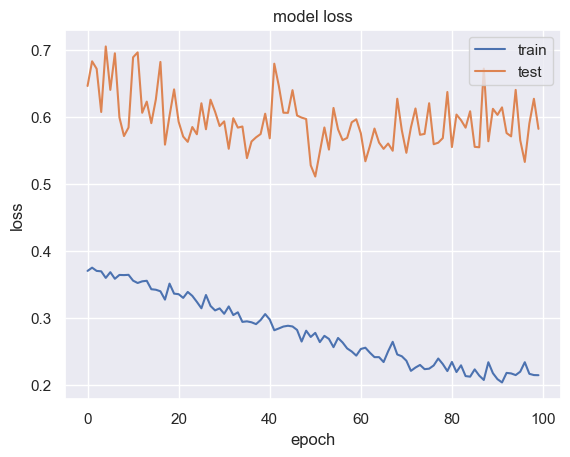

In [393]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()